### An Introduction to Value At Risk

#### Introduction

Let $X$ be a random variable describing our financial position,
so that higher values of $X$ represent convenient outcomes.
We are interested in modeling its associated *risk*.
A quick description is offered by the standard variation $\sigma(X)$, 
since it determines how likely scenarios far from the expected value are 
(Chebyshev inequality).

When dealing with Financial risk, this notion reveals its limitations.

There is indeed a far greater interest in predicting unexpected *losses*, 
*unfavorable* outcomes, while the variance does not differentiate
between "positive" or "negative" events
(due to its squared difference in the definition),
motivating the research towards more complex approaches.

#### Monetary Risk Measures: cash-invariance and acceptability

Let now $\rho :  \mathbb{R} \to \mathbb{R}$ be a generic function,
candidate to measure the "risk" in a generalized way.
The literature is vast and offers dozens of definitions,
each with pros and cons, as for instance described in the
book *Stochastic Finance* (Follmer).
We focus here on some
key mathematical propereties and move later to the simplest
"realistic" case (*Value at Risk*).

Generally speaking, lower values of $\rho(X)$ must always indicate
more "convenient" scenarios ("risk minimization"). The two most common
mathematical requirements are:
 - *monotonicity*: $X \leq Y$ implies $\rho(Y) \leq (X)$;
 - *cash-invariance*: $\rho(X + m) = \rho(X) - m$ for each $m \in \mathbb{R}$;

Monotonicity simply means that if the financial position $Y$ always ensures
a better gain than $X$, then its risk is inferior.
The cash-invariance property is interpreted as follows:
if we had more money $m$ at
disposal when getting a position $X$, the overall risk would reduce since that
capital could be used to countereffect possible negative outcomes, leading to
better overall final position (e.g. avoiding bankrupt).

Any position $X$ is called *acceptable* if and only if $\rho(X) \leq 0$.

Proposition: The quantity $\rho(X)$ is the smallest amount of money that,
when added to the position $X$, makes it acceptable.

Proof: for any $m \geq \rho(X)$ we have
$\rho(X + m) = \rho(X) - m \leq \rho(X) - \rho(X) = 0$, therefore the position
is accepted. 
The converse holds for any $m < \rho(X)$.

#### Quantiles of a random variable

This section is on a first sight independent from the part above,
but the two topics will merge later when discussing the Value At Risk.

Let $X$ be a real random variable.
The comulative distribution function 
$F_X: \mathbb{R} \to [0,1]$
of $X$ is defined as $F(t) = P[X \leq t ]$.

Generally speaking, the map above is non-decreasing 
and continuos from the right,
but for simplicity we assume full continuity and strict monotonicity.

Under these conditions, it is possible to easily define
its inverse function called the quantile function 
$Q_X: [0,1] \to \mathbb{R}$ as
$Q_X(p) = F^{-1}(p) = t$, 
with $t$ the only value such that
$P[X \leq t] = p$.

Quantile represents a very strong tool to study probability distributions
and can be generalized to less regular cases.
Important statistical tests (like the Q-Q) are based on this notion,
and we encourage the reader in searching more on the topic.

We point out two properties very useful later:
 - for every $m \in \mathbb{R}$ and
      $p \in [0,1]$, we have $Q_{X+m}(p) = Q_{X}(p) + m$
 - if $X \leq Y$, then $Q(X) \leq Q(Y)$.

The first proof follows by writing explicitely the quantile definition
on both sides. For the second observe that $X \leq Y$ implies
$P[X \leq k] \geq P[Y \leq k]$ and conclude replacing $k$ with quantiles.

We conclude this section by proposing a way to approximate quantiles
from a computational viewpoint.
Let's suppose to have $N$ samples coming from the random variable $X$, 
with interest in approximating the $p$ quantile,
i.e. the value $Q(p)$ such that $P[X \leq Q(p)] = p$.
An approximation for $Q(p)$ is chosen between the available samples.


Proposed algorithm:
 - sort all the samples $X_0, \dots, X_{N-1}$ in ascending oder;
 - take $k = floor(N p)$ (Recall: the floor operation approximates to
       the imediate previous integer, e.g. floor(3.7) = 3);
 - if $k \geq 1$, then we take as approximated quantile the number
       $X_{k-1}$ (more explanation follows).
       Otherwise we can only claim that the quantile is stricly
       inferior than $X_0$.
      We return $X_0$, but with an attached warning message.


Observing that for any $x \in \mathbb{R}$ we have
$floor(x) \leq x < floor(x) + 1$, and since the samples are sorted
with indeces starting from $0$, the following holds:
 - $P[X \leq X_{k-1}] = \frac{k}{N} = 
        \frac{floor(N p)}{N} \leq \frac{Np}{N} = p$
 - $P[X \leq X_{k}] = \frac{k+1}{N} =
       \frac{floor(Np) + 1}{N}> \frac{Np}{N} = p$


Therefore, on the base of the empirical samples,
the true quantile satisfying
$P[X \leq Q(p)] = p$ must lie in the interval
$[X_{k-1}, X_{k})$.

For simplicity we return the value $X_{k-1}$.
The following code implements these ideas.

In [2]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def get_quantile (given_samples : np.array, p : float,
                            verbose=True) -> float:
    '''
    The array given_samples contains the samples (real numbers), while
    p is the target probability strictly between 0 and 1.
    The function returns a quantile estimation according to the sorting
    strategy.
    '''
    assert(p > 0. and p < 1.)
    # Sort samples in ascending order
    samples = np.sort(given_samples.reshape(-1,))
    n_samples = samples.shape[0]
    assert(n_samples >= 2)
    # Convert the probability p into "how many elements" 
    # from the sorted samples has to be taken until reaching p.
    # Example: if the samples are 100 sorted number, 
    # take the first 80 to realize the 80% quantile.
    idx_low = int(np.floor(n_samples * p))
    if idx_low == 0:
        print(f"Quantile {p} is too small for num samples {n_samples}")
        return samples[0]
    # this is the "k" in the notation above
    idx_up = int(idx_low)
    # and "k-1" is the index idx_low
    idx_low = idx_up - 1
    # q_low is the lower bound in the interval, while...
    q_low = samples[idx_low]
    # q_up is the upper bound.
    q_up = samples[idx_up]
    # Double check that the two elements approximate the desired quantile
    p_low = np.sum(samples <= q_low) / n_samples
    p_up = np.sum(samples <= q_up) / n_samples
    # We must have: p_low <= p, and p_up > p.
    if not ((p_low <= p) and (p_up > p)):
        print(f"{p_low} > {p} or {p_up} <= {p}")
        assert False
        # I need to adjust a bit better the code above
        
    
    if verbose:
        print(f"From get_quantile:")
        print(f"\t{p*100:.3f}%-quantile in [{q_low:.3e}, {q_up:.3e})")
        print(f"\t{p*100:.3f}%-quantile is {q_low:.3e}") 
        print(f"\tP [X <= {q_low :.3e}] = {p_low : .3e} <= {p : .3e}")
        print(f"\tP [X <= {q_up:.3e}] = {p_up : .3e} > {p : .3e}")
        print("-")
    return q_low
#---


In [4]:
def error_analysis(true_value, p):
        '''
        Perform an error analysis for the get_quantile
        function, based on the known quantile values for the normal
        distribution.
        '''
        n_exponents = 5
        base = 5
        exponents = range(base, base + n_exponents)
        mean_errors = []
        for power in exponents:
                n_simulations = 100
                n_samples = int(math.pow(2., power))
                simu_errors = np.zeros(n_simulations)
                for nth_simu in range(n_simulations):
                        samples = np.random.normal(0., 1., (n_samples,)) 
                        result = get_quantile(samples, p, verbose = False)
                        tmp = np.abs(true_value - result)
                        # choose relative errors
#                        simu_errors[nth_simu] = tmp * 100. / np.abs(true_value)
                        # or choose absolute errors
                        simu_errors[nth_simu] = tmp
                mean_errors.append(simu_errors.mean())
        return (exponents, mean_errors)
#----

In [5]:
err_1, res_1 = error_analysis(1.6449, 0.95)
err_2, res_2 = error_analysis(-0.8416, 0.20)
err_3, res_3 = error_analysis(0., 0.50)
err_4, res_4 = error_analysis(-1.96, 0.025)

Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.025 is too small for num samples 32
Quantile 0.02

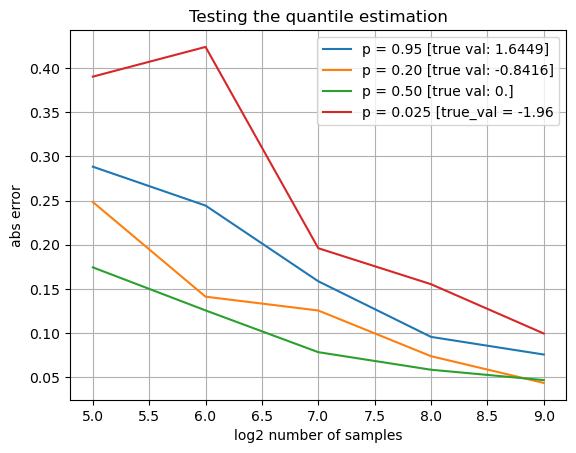

In [6]:
plt.plot(err_1, res_1, label = "p = 0.95 [true val: 1.6449]")
plt.plot(err_2, res_2, label = "p = 0.20 [true val: -0.8416]")
plt.plot(err_3, res_3, label = "p = 0.50 [true val: 0.]")
plt.plot(err_4, res_4, label = "p = 0.025 [true_val = -1.96")
plt.grid()
plt.title("Testing the quantile estimation")
plt.xlabel("log2 number of samples")
plt.ylabel("abs error")
plt.legend()
plt.show()

#### Value At Risk: a Monetary Risk Measure based on Quantiles

The Value At Risk is a monetary risk measure based on the notion of quantile.

For a financial position $X$, the *Value At Risk* is the map
$V_@R(X): [0, 1] \to \mathbb{R}$
defined as:

$V_@R_\lambda(X) = - Q_X(\lambda)$

Proposition: the Value At Risk is a monetary risk measure.

Proof:
This is a direct consequence of the properties shown for quantiles.
When $X \leq Y$ we have $Q_X \leq Q_Y$ and therefore
$V_@R(X) \geq V_@R(Y)$ as required.
Concerning the cash-invariance property,
use the quantile translational invariance:

$V_@R_\lambda(X + k) =
        - Q_{(X + k)}(\lambda) = 
        - Q_X(\lambda) - k =
        V_@R_\lambda(X) - k
$

The next goal is to develop more intuition about how to interpret the
value at risk.

We start by observing how, directly by its definition,
we always have:

$P [ X + V_@R_\lambda(X) \leq 0] = \lambda$

Therefore $V_@R$ can here be read as an amount of money that, if added to
$X$, would make negative outcomes stay under the probabiility
$\lambda$ (chosen usually very small, around $0.05$).

In case the financial position $X$ is acceptable, 
i.e. $\rho(X) = V_@R(X) \leq 0$ already,
it means indeed that there is no need to add any further capital:
the random events distributes already the probability treshold.

Othewise, because $V_@R$ is a monetary risk measure and we proved it in the
first section, $V_@R(X)$ would repredent the *minimal* amount of monety 
needed to be added to
$X$ to make it acceptable, i.e. to control the overall probability of loss
by the probability $\lambda$.

There is no further remark on the computational aspect of this risk indicator,
since it would be enough to use the algorithm proposed for the quantile
in the section before.